<a href="https://colab.research.google.com/github/vallekarla123-collab/Examen-Econometr-a-A01452031/blob/main/Examen_Econometria_preg_19_A01452031.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Por favor, sube el archivo Excel: 'PDI.xlsx'


Saving Información códio GROK pregunta 19.xlsx to Información códio GROK pregunta 19 (3).xlsx

Archivo cargado: Información códio GROK pregunta 19 (3).xlsx
Columnas: ['Date', 'GS3M', 'GS6M']
Columna de fecha: Date
Rango: 1982-01 → 1985-12

Primeras filas:
             GS3M   GS6M
Date                    
1982-01-01  12.92  13.90
1982-01-01   7.97   8.63
1982-02-01  14.28  14.81
1982-03-01  13.31  13.83
1982-04-01  13.34  13.87


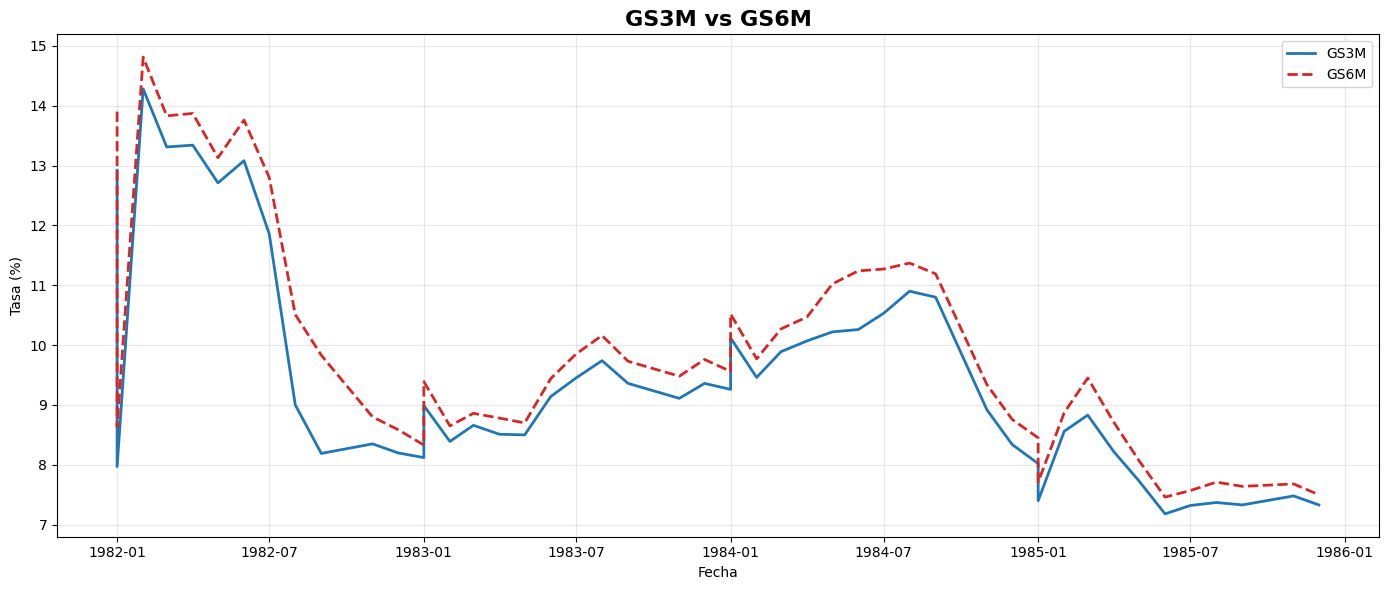



==================== ESTACIONARIEDAD: GS3M ====================
ADF  → p-value: 0.031150 → Estacionaria
KPSS → p-value: 0.042827 → NO estacionaria (tendencia)
Conclusión: NO ESTACIONARIA


==================== ESTACIONARIEDAD: GS6M ====================
ADF  → p-value: 0.039754 → Estacionaria
KPSS → p-value: 0.037783 → NO estacionaria (tendencia)
Conclusión: NO ESTACIONARIA


Ambas series NO son estacionarias → Procedemos con Johansen.

========================= JOHANSEN COINTEGRATION TEST =========================
Usando 48 observaciones.

Rezagos en VAR: 1 | Tendencia: No
rango  Trace Stat   Crit 90%   Crit 95%   Crit 99%   Resultado
----------------------------------------------------------------------
r<=0   24.509       13.429     15.494     19.935     Cointegrada
r<=1   1.310        2.705      3.841      6.635      No cointegrada

Conclusión (95%): SÍ HAY COINTEGRACIÓN

Vector de cointegración (aprox):
  GS3M + -0.9061 * GS6M = error estacionario

                               

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import warnings
warnings.filterwarnings("ignore")

# ====================== CARGA Y LIMPIEZA DE DATOS ======================
def load_stock_data():
    print("Por favor, sube el archivo Excel: 'PDI.xlsx'")
    uploaded = files.upload()
    filename = list(uploaded.keys())[0]

    try:
        df = pd.read_excel(filename)
        print(f"\nArchivo cargado: {filename}")
        print(f"Columnas: {list(df.columns)}")

        # Detectar columna de fecha
        date_candidates = [col for col in df.columns if any(x in col.lower() for x in ['data', 'date', 'año', 'mes'])]
        if not date_candidates:
            raise ValueError("No se encontró columna de fecha.")

        date_col = date_candidates[0]
        print(f"Columna de fecha: {date_col}")

        # Convertir año.mes → datetime
        df[date_col] = df[date_col].astype(str).str.strip()
        df[date_col] = pd.to_datetime(df[date_col].replace(r'\.', '-', regex=True), format='%Y-%m', errors='coerce')

        if df[date_col].isna().any():
            temp = df[date_col].astype(str).str.split('.', expand=True)
            if temp.shape[1] >= 2:
                year = temp[0].astype(int)
                month = temp[1].astype(int).clip(1, 12)
                df[date_col] = pd.to_datetime(year.astype(str) + '-' + month.astype(str).str.zfill(2) + '-01')

        df.set_index(date_col, inplace=True)
        df.sort_index(inplace=True)
        print(f"Rango: {df.index.min().strftime('%Y-%m')} → {df.index.max().strftime('%Y-%m')}")

        return df

    except Exception as e:
        raise ValueError(f"Error: {e}")

# ====================== GRÁFICA ======================
def plot_time_series(df, col1='GS3M', col2='GS6M'):
    plt.figure(figsize=(14, 6))
    plt.plot(df.index, df[col1], label=col1, color='tab:blue', linewidth=2)
    plt.plot(df.index, df[col2], label=col2, color='tab:red', linewidth=2, linestyle='--')
    plt.title(f'{col1} vs {col2}', fontsize=16, fontweight='bold')
    plt.xlabel('Fecha')
    plt.ylabel('Tasa (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# ====================== ESTACIONARIEDAD ======================
def test_stationarity(series, name):
    print(f"\n{'='*20} ESTACIONARIEDAD: {name} {'='*20}")
    series = series.dropna()
    if len(series) < 10:
        print("Muestra muy pequeña.")
        return False

    adf = adfuller(series, autolag='AIC')
    adf_p = adf[1]
    print(f"ADF  → p-value: {adf_p:.6f} → {'Estacionaria' if adf_p < 0.05 else 'NO estacionaria'}")

    kpss_stat, p_val, _, _ = kpss(series, regression='c', nlags="auto")
    print(f"KPSS → p-value: {p_val:.6f} → {'Estacionaria' if p_val >= 0.05 else 'NO estacionaria (tendencia)'}")

    is_stat = (adf_p < 0.05) and (p_val >= 0.05)
    print(f"Conclusión: {'ESTACIONARIA' if is_stat else 'NO ESTACIONARIA'}\n")
    return is_stat

# ====================== JOHANSEN COINTEGRATION TEST ======================
def johansen_cointegration_test(df, col1='GS3M', col2='GS6M', det_order=0, k_ar_diff=1):
    """
    Aplica Johansen Cointegration Test a dos series.
    det_order: 0 (sin tendencia), 1 (con tendencia)
    k_ar_diff: rezagos en el VAR (1 por defecto)
    """
    print(f"\n{'='*25} JOHANSEN COINTEGRATION TEST {'='*25}")

    # Preparar datos: solo las dos columnas
    data = df[[col1, col2]].dropna()
    if len(data) < 20:
        print("Advertencia: Muestra muy pequeña para Johansen.")
        return

    print(f"Usando {len(data)} observaciones.")

    # Ejecutar Johansen
    result = coint_johansen(data.values, det_order=det_order, k_ar_diff=k_ar_diff)

    # Estadísticos de traza y valores críticos
    trace_stat = result.lr1
    trace_crit = result.cvt
    max_eig_stat = result.lr2
    max_eig_crit = result.cvm

    print(f"\nRezagos en VAR: {k_ar_diff} | Tendencia: {'Sí' if det_order else 'No'}")
    print(f"{'rango':<6} {'Trace Stat':<12} {'Crit 90%':<10} {'Crit 95%':<10} {'Crit 99%':<10} {'Resultado'}")
    print("-" * 70)

    cointegrated = False
    for r in range(len(trace_stat)):
        stat = trace_stat[r]
        crit_95 = trace_crit[r, 1]  # 95%
        result_str = "Cointegrada" if stat > crit_95 else "No cointegrada"
        if stat > crit_95 and not cointegrated:
            cointegrated = True
        print(f"r<={r:<3} {stat:<12.3f} {trace_crit[r,0]:<10.3f} {crit_95:<10.3f} {trace_crit[r,2]:<10.3f} {result_str}")

    # Conclusión
    conclusion = "SÍ HAY COINTEGRACIÓN" if cointegrated else "NO HAY COINTEGRACIÓN"
    print(f"\nConclusión (95%): {conclusion}")

    # Mostrar vector de cointegración si existe
    if cointegrated:
        eig_vec = result.evec[:, 0]  # Primer vector
        print(f"\nVector de cointegración (aprox):")
        print(f"  {col1} + {eig_vec[1]/eig_vec[0]:.4f} * {col2} = error estacionario")

    return cointegrated

# ====================== EJECUCIÓN COMPLETA ======================
# 1. Cargar datos
df = load_stock_data()

# 2. Ver datos
print("\nPrimeras filas:")
print(df[['GS3M', 'GS6M']].head())

# 3. Graficar
plot_time_series(df)

# 4. Pruebas de estacionariedad
print("\n" + "="*80)
is_gs3m_stat = test_stationarity(df['GS3M'], "GS3M")
is_gs6m_stat = test_stationarity(df['GS6M'], "GS6M")

# 5. Johansen Cointegration (solo si ambas NO son estacionarias)
print("\n" + "="*80)
if not is_gs3m_stat and not is_gs6m_stat:
    print("Ambas series NO son estacionarias → Procedemos con Johansen.")
    coint = johansen_cointegration_test(df, 'GS3M', 'GS6M', det_order=0, k_ar_diff=1)
else:
    print("Al menos una serie es estacionaria → No se requiere cointegración.")
    coint = False

# 6. RESUMEN FINAL
print("\n" + "="*80)
print("RESUMEN FINAL".center(80))
print(f"GS3M → {'ESTACIONARIA' if is_gs3m_stat else 'NO ESTACIONARIA'}")
print(f"GS6M → {'ESTACIONARIA' if is_gs6m_stat else 'NO ESTACIONARIA'}")
print(f"COINTEGRACIÓN → {'SÍ' if coint else 'NO'}")
print("="*80)

In [7]:
# PARA EXPORTAR

from google.colab import files
import nbformat
from nbconvert import HTMLExporter

# Paso 1: Cargar tu archivo .ipynb
print("Por favor, selecciona tu archivo .ipynb")
uploaded = files.upload()

# Paso 2: Obtener el nombre del archivo cargado
notebook_filename = list(uploaded.keys())[0]
print(f"\nArchivo cargado: {notebook_filename}")

# Paso 3: Leer el notebook
with open(notebook_filename, 'r', encoding='utf-8') as f:
    notebook = nbformat.read(f, as_version=4)

# Paso 4: Convertir a HTML
print("Convirtiendo a HTML...")
html_exporter = HTMLExporter()
html_exporter.template_name = 'classic'
(body, resources) = html_exporter.from_notebook_node(notebook)

# Paso 5: Guardar el archivo HTML
html_filename = notebook_filename.replace('.ipynb', '.html')
with open(html_filename, 'w', encoding='utf-8') as f:
    f.write(body)

print(f"Conversión completada: {html_filename}")

# Paso 6: Descargar el archivo HTML
print("Descargando archivo HTML...")
files.download(html_filename)
print("¡Listo! Tu archivo HTML ha sido descargado.")

Por favor, selecciona tu archivo .ipynb


Saving Examen_Econometria_preg_19_A01452031 (1).ipynb to Examen_Econometria_preg_19_A01452031 (1).ipynb

Archivo cargado: Examen_Econometria_preg_19_A01452031 (1).ipynb
Convirtiendo a HTML...
Conversión completada: Examen_Econometria_preg_19_A01452031 (1).html
Descargando archivo HTML...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

¡Listo! Tu archivo HTML ha sido descargado.


Interpretaciones:

A) Tienen un comportamiento muy parecido a lo largo del tiempo. Ambas suben y bajan de manera casi simultánea, lo que muestra que se mueven en la misma dirección y responden a las mismas condiciones económicas. No hay cambios bruscos ni divergencias marcadas, sino una trayectoria paralela que refleja estabilidad en su relación.

C) Las dos series de tiempo, GS3M y GS6M, no son estacionarias por separado, pero sí están cointegradas según la prueba de Johansen, ya que el estadístico traza (24.509) supera el valor crítico al 95% (15.494). Esto significa que ambas tasas de interés se mueven de forma conjunta en el largo plazo y mantienen una relación de equilibrio estable.

D) La cointegración entre las tasas GS3M y GS6M significa que, aunque ambas se mueven de forma independiente en el corto plazo, mantienen una relación de equilibrio a largo plazo. En términos económicos, esto refleja que las tasas de interés de corto plazo están vinculadas por los mismos factores macroeconómicos, como la política monetaria, las expectativas de inflación o la oferta y demanda de dinero. Si una de las tasas sube o baja de manera temporal, la otra tiende a ajustarse en la misma dirección para mantener la diferencia entre ellas relativamente constante. Si las dos series no estuvieran cointegradas, significaría que no existe una relación de equilibrio de largo plazo entre las tasas. En ese caso, cada tasa podría seguir su propio comportamiento sin ajustarse a la otra, lo que implicaría que el mercado financiero no mantiene coherencia entre los plazos. Económicamente, esto podría interpretarse como ineficiencia o desalineación temporal en la política monetaria o en las expectativas de los inversionistas, donde las tasas a corto y mediano plazo no responden de manera coordinada a los mismos factores económicos.

E) Ambas series, son no estacionarias en niveles, pero están cointegradas. Esto significa que, aunque cada una presenta una tendencia propia, se mueven de manera conjunta manteniendo una relación de equilibrio a largo plazo. Por esa razón, considero que sí puedo realizar el análisis en niveles, ya que si aplicara primeras diferencias eliminaría esa relación estructural entre las dos tasas. Al trabajar en niveles, el modelo puede reflejar tanto los ajustes de corto plazo como la convergencia hacia el equilibrio de largo plazo.